In [ ]:
#######################################
Input: 
animal_groups_to_ref.vcf(VCF file with variant calls per animal group)
    
Function: 
Change the VCF format to a format where genotypes are defined per group in a 0/0 1/0 etc. format. and
write this of to a CSV file.

Output:
CSV file with genotypes per animal group per scaffold position.
#######################################

In [ ]:
#Get genotype from VCF per sample and scaffold pos
library(vcfR)
vcf <- read.vcfR("/workspace/hramzr/vcf_file_generation/01.freebayes/animal_groups_to_ref.vcf", checkFile=F)
gt <- extract.gt(vcf, element = c('GT'))
?extract.gt
library(dplyr)
library(data.table)
write.csv(gt, "geno.csv")

In [ ]:
#######################################
Function: 
Run the cell above on the cluster for big size computation, as it was tested in reduced size.
#######################################

In [ ]:
#run 2 cells above, but in a fashion that enables big size computation
module load R/3.4.3 
bsub -n 8 -e Rerror.err "Rscript Convert_VCF_to_genotype_table.r"

In [ ]:
#######################################
Input: 
geno.csv(csv file with genotypes, unordened per sex)

Function: 
The goal of this cel is to order all columns from male to female and to change all values to strings in order to turn the
strings to unique integers later on, which is needed for the chi square test.

Output:
ordered_csv.csv(csv file with columns ordered from males to females and with all values in string format)
#######################################

In [ ]:
import pandas as pd
#read csv in python
df = pd.read_csv("/workspace/hramzr/Fisher_tests/geno.csv", index_col=0)
df
#insert order of male to female
df = df[["01_group", "03_group", "05_group", "09_group",
         "11_group", "12_group", "13_group", "02_group",
         "04_group", "06_group", "07_group", "08_group", "10_group"]]

df = df.applymap(str)
df.to_csv("ordered_csv.csv", sep='\t', encoding='utf-8')

In [ ]:
#######################################
Input: 
ordered_csv.csv(file with ordered genotype BAM groups, header included)

Function: 
remove column identifiers as these are not necessary for the factorization step which will come next, 
as this will happen per line.

output:
loopfile.txt(file ready to be looped line for line with genotypes, with the headers removed)
#######################################

In [ ]:
cat ordered_csv.csv | tail -n +2 > loopfile.txt

In [ ]:
#######################################
Input:
Loopfile.txt(file with genotypes per region across sex groups.

Function: 
1. Read each line with genotypes per region and factorize the strings to unique integers, for them to be read by the chi square test.
2. Get a count of unique integers per gender to make a dynamic table.
3. Run this table and store the p-value along with the scaffold name and position in a text file called chi_data.

output:
chi_data(file with scaffold name, pos and p_value per region)
#######################################

In [ ]:
#Factorize the strings to unique integers
import pandas as pd
f = open("loopfile.txt", "r")
f = f.readlines()

list_of_unique_indexes=[]
for line in f:
    line = line.split()
    values = line[1:]
    s = pd.Series(values)
    s = pd.factorize(s)[0] + 1
    final_line = s.tolist()
    final_line.insert(0,line[0])
    list_of_unique_indexes.append(final_line)

import numpy as np
import scipy.stats as stats
import collections
f = open("chi_data", "w")
for line in list_of_unique_indexes:
    
#split line in male and female variants
    male = line[1:8]
    female = line[8:]
    
#Count each unique integer per variant and put them in a dictionary per male and female next make a list of lists with 
#every unique value's counts per gender
    varlist= []
    counterM=collections.Counter(male)
    counterF=collections.Counter(female)
    for i in range(max(line[1:])):
        varlist.append([counterM[i+1], counterF[i+1]])

#Turn the list of lists to a np.array and calculate the chi2_stat, p_val, dof, ex with the chi_square test.
    table = np.array(varlist)
    chi2_stat, p_val, dof, ex = stats.chi2_contingency(table)    

#p_value 1.0 means no difference between samples lower than 1.0 means a difference the lower the more difference
    
#write scaffold name, pos and p_value to chi_data out  
    out = line[0].split("_")
    out.append(p_val)
    finallist =[out[0], int(out[1]), out[2]]
    f.write(str(finallist).replace("[", "").replace("]", "").replace(",", "")+"\n")
f.close()
    


In [ ]:
#######################################
Function: 
Run the cell above on the cluster for big size computation, as it was tested in reduced size.
#######################################

In [ ]:
#run fact and chisq cell above
module load pfr-python3/3.6.5
# module avail
bsub -n 8 -e pyerror.err "python Factorize_and_chisq.py"

In [ ]:
#######################################
Input:
chi_data(file with scaffold name, pos and p_value per region)

Function: 
Get the average p_value per 500 bases in order to remove outliers and to keep this value similar to that of 
other tests for comparing.   
    
Output:
meansp.txt(file with scaffold name, pos and p_value per 500b region)
#######################################

In [ ]:
#means per tick of 500 positions, in order to rid of outliers.
library(data.table)
library(ggplot2)
library(dplyr)

df <- read.table("/workspace/hramzr/Fisher_tests/chi_data", header = FALSE)
col_names <- c("SCAFFOLD", 'POS', "PVAL" )
colnames(df) <- col_names
with_bins <- mutate(df, bin_start=(ceiling(POS/500)*500)-500)
by_bin <- group_by(with_bins, bin_start, SCAFFOLD)
by_bin$POS <- NULL
bin_means <- summarise(by_bin, PVAL = mean(PVAL))
bin_means <- mutate(bin_means, minus_log10_P=-log10(PVAL))
write.table(bin_means, file = "meansp.txt", sep = "\t",
            row.names = FALSE, col.names = FALSE)

In [ ]:
#######################################
Input:
meansp.txt(file with -log10P values and scaffold data)

Function: 
Filter the regions with a -log10P threshold, for plot making and comparative analysis with the other tests.

Output:
var[variable identifier, based on threshold](file with regions that are filtered by a specific -log10P value)
#######################################

In [ ]:
#filter out on -log10p threshold
# cat meansp.txt | awk '{ if($4 > 1.5) { print }}'>var1d5
# cat meansp.txt | awk '{ if($4 > 2.0) { print }}'>var2d0
# cat meansp.txt | awk '{ if($4 > 2.5) { print }}'>var2d5
# cat meansp.txt | awk '{ if($4 > 2.8) { print }}'>var2d8
cat meansp.txt | awk '{ if($4 > 1.56) { print }}'>var1d56

In [ ]:
#######################################
Input:
var[1d5, 2d0, 2d5 and 2d8](filtered files with scaffold names, regions and -log10P values)

Function: 
Plot the scaffolds of threshold filtered files.

Output:

Visualised plots.
#######################################

Text(0.5,1,'Scatterplot position versus confidence rate')

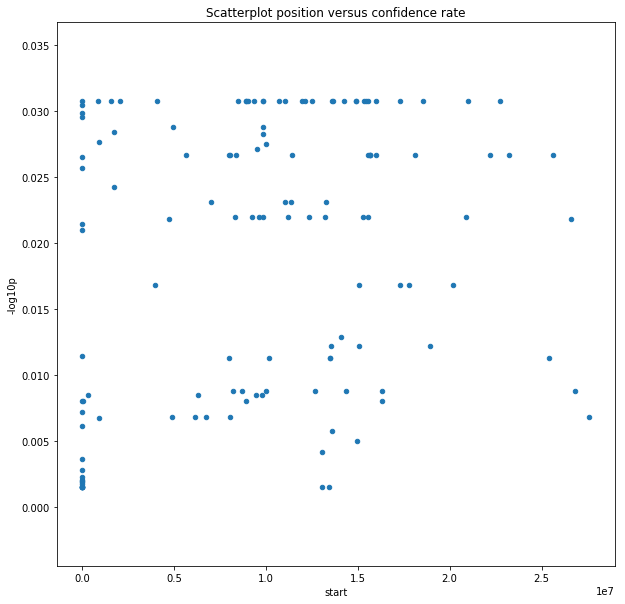

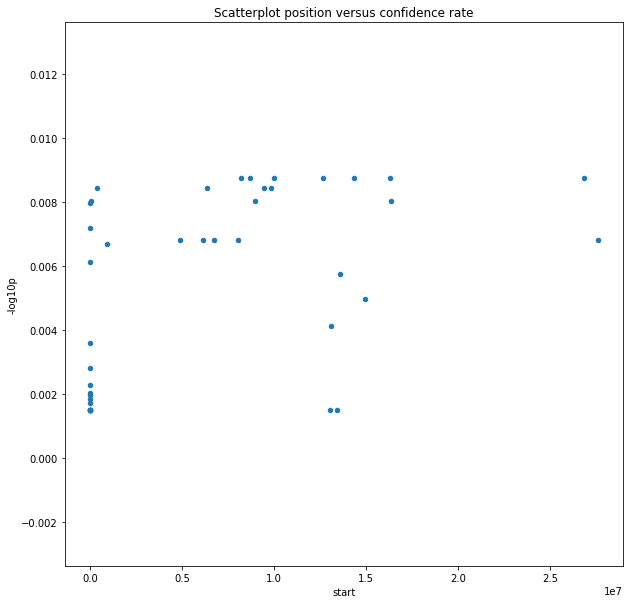

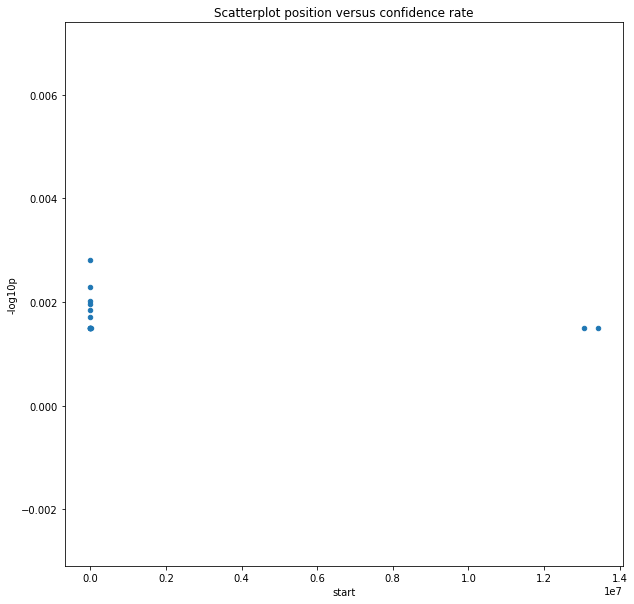

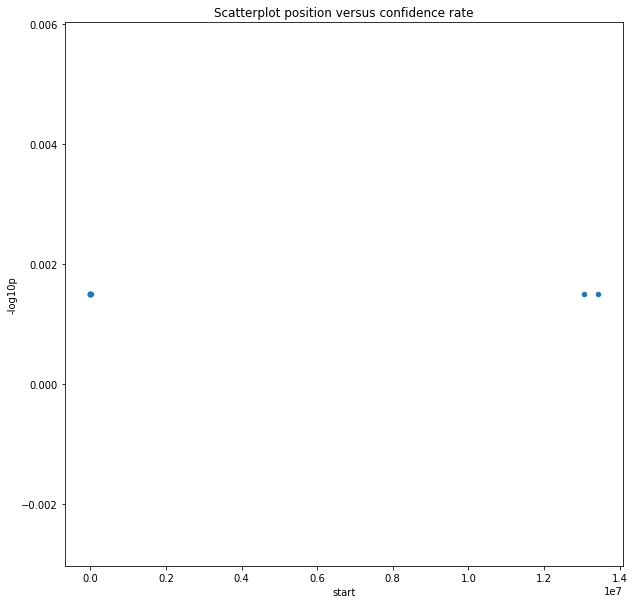

In [2]:
#scatterplot results
import pandas 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#-log10p 1.5
df  = pd.read_csv("/workspace/hramzr/Fisher_tests/var1d5", delimiter="\t", header=None)
plot1 = df.plot(kind='scatter',x=0 ,y=2,figsize=(10,10)) # scatter plot
plot1.set_ylabel("-log10p")
plot1.set_xlabel("start")
plot1.set_title("Scatterplot position versus confidence rate")

#-log10p 2.0
df  = pd.read_csv("/workspace/hramzr/Fisher_tests/var2d0", delimiter="\t", header=None)
plot2 = df.plot(kind='scatter',x=0 ,y=2,figsize=(10,10)) # scatter plot
plot2.set_ylabel("-log10p")
plot2.set_xlabel("start")
plot2.set_title("Scatterplot position versus confidence rate")

#-log10p 2.5
df  = pd.read_csv("/workspace/hramzr/Fisher_tests/var2d5", delimiter="\t", header=None)
plot2 = df.plot(kind='scatter',x=0 ,y=2,figsize=(10,10)) # scatter plot
plot2.set_ylabel("-log10p")
plot2.set_xlabel("start")
plot2.set_title("Scatterplot position versus confidence rate")

#-log10p 2.8
df  = pd.read_csv("/workspace/hramzr/Fisher_tests/var2d8", delimiter="\t", header=None)
plot2 = df.plot(kind='scatter',x=0 ,y=2,figsize=(10,10)) # scatter plot
plot2.set_ylabel("-log10p")
plot2.set_xlabel("start")
plot2.set_title("Scatterplot position versus confidence rate")